<a href="https://colab.research.google.com/github/MikeNsiah10/Colab_project/blob/main/Copy_of_Problem_Set_3_(2024_25).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<font size = 10> <b> Problem Set 3 </b>
<br>
<font size = 5> <b> Neural Network Modeling </b>

<div class="row">
            <img src="https://i.imgur.com/5Fjnaid.gif"
            width=500 height=250> </img>
             
</div>

</center>

## <font color="green">**Exercise 0 - Run this cell<br> (0 points)**

In [ ]:
# Run this cell to load the following libraries
!pip install cm-course-uos --upgrade

from cm_course_uos import problemset3

import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set the seed
random.seed(12)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.5 MB/s eta 0:00:00


## **Outline<br>**

This problem set is composed of two parts, each introducing different aspects of neural network modeling in the context of the Stroop Model--a neural network model of cognitive control.

**1.  Modeling Information Processing in the Stroop Model:** The part introduces basic concepts of processing in neural networks. We get to explore how neural networks can be used as a model of cognitive control, as exemplified in the Stroop task.

**2.  Model Fitting with the Stroop Model:** The second part reintroduces basic concepts of fitting. In this part, we build on the neural network model of the Stroop task and will fit the model---without using backpropagation!

Before diving into the respective parts, we introduce the neural network model we are working with: the Stroop Model.


## **Background: The Stroop Model<br>**

The Stroop model operationalizes mental effort as cognitive control, that is, our ability to override habitual responses in order to align behavior with current task goals. For instance, you may be familiar with the so-called Stroop task in which participants have to name the color of a color word, e.g., say "green" in response to:

<font color="green" size=13> **RED** </font>

We call this stimulus "incongruent" because the color and the word are associated with different responses. A congruent stimulus looks like this:

<font color="green" size=13> **GREEN** </font>

Finally, there may be so-called neutral stimuli in which the participant has to respond to the color of a non-word:

<font color="green" size=13> **XXXX** </font>

When studying human performance in the Stroop task, one can measure the error rate as a function of stimulus condition (neutral, incongruent, congruent), and as function of which task the participant performs (color naming or word reading).

Cohen et al. (1990) came up with a neural network model that operationalizes mental effort. The model is depicted as following (adapted from Figure 1 of Cohen et al., 1990):

<p align='center'><img src='https://raw.githubusercontent.com/jmasis/nntutorialmentaleffort2021/main/stroop_neural_network_simple.png'
alt="3-layer network with bias units" width=650px height=auto/></p>

The network consists of three input layers, two hidden layers and one output layer. The input layer on the left encodes the ink color of the stimulus. For instance, if the stimulus was shown in red, we may set the input vector for the INK COLOR layer to $\begin{bmatrix} 1 & 0 \end{bmatrix}$. The input layer on the right encodes the current word. If the word is "GREEN" then we can set the word input layer to $\begin{bmatrix} 0 & 1 \end{bmatrix}$. Finally, the input layer in the middle encodes the task to be performed on the two stimuli. An illustration of this might be given if the participant would be asked to perform the color naming task, one would set the input units of the task demand layer to $\begin{bmatrix} 1 & 0 \end{bmatrix}$.

The input layers project to two hidden layers, one that represents colors and another one that represents words. E.g., the first unit in the color hidden layer represents the color red. Note that inhibitory connections (negative weights) are depicted as dashed arrows. Finally, both hidden layers project to respective response units in the output layer.

Note that the output layer receives inputs from two sources, the color hidden layer and the word hidden layer. Thus, **if the information represented in the color and word hidden layers is incongruent, then the output layer will receive conflicting responses.** However, an important feature of the Stroop Model is that the hidden and output units are inhibited at rest. That is, these units receive a negative weight from a bias unit. Thus, a more accurate depiction of the network would be:

<p align='center'><img src='https://raw.githubusercontent.com/jmasis/nntutorialmentaleffort2021/main/stroop_neural_network.png'
alt="3-layer network with bias units" width=650px height=auto/></p>

where the green units are bias units whose activity is always 1 and whose weight is negative. You can think of a bias as a constant term added to the net input of a unit:

\begin{equation}
net_{y_j} = \sum_{i=1}^M x_i w_{j,i} + \text{bias}
\end{equation}

Here, we assume that the bias is inhibitory, so we set $\text{bias} < 0$.
The inhibition introduced by the bias units is so strong that, without any input from the *TASK DEMAND* layer, the information from the color and word input layers would not "make it through" the hidden layers to the output layer. This is because adding a negative bias pushes the non-linear activation function to the right.

<p align='center'><img src='https://github.com/jmasis/nntutorialmentaleffort2021/blob/326079df67a7bfe602d30d6aee246b64f53b0f39/BiasEffect.png?raw=True'
alt="Effect of bias on sigmoidal activation function" width=400px height=auto/></p>

As a consequence, small net inputs will evaluate to something close to zero. However, the cool part about the Stroop model is that the **TASK DEMAND** layer can provide additional net input to the hidden units, making it possible to disinhibit them. For instance, if we set the color naming unit to 1, then we can provide additonal net input to the color hidden units. This negates the negative bias, allowing information from the **INK COLOR** input layer to flow through to the **RESPONSE** layer. Conversely, if we leave the word reading unit in the **TASK DEMAND** layer at 0, then the information from the **WORD** layer cannot leak through. The output layer would then only receive input from the color hidden units, thus enabling the network to perform the color naming task. This provides a mechanism for cognitive control: allocating cognitive control to a task means to activate a task demand unit (i.e., set it to 1).

Now that you are familiar with the Stroop Model, let's start implementing the model.

# <font >**Part 1: Modeling Information Processing in the Stroop Model<br>**

## <font color="green">**Exercise 1 - Compute Activations for hidden and output layers<br> (6 points)**

### <font>**How do we compute a neuron's net activation?<br>**

As discussed in the lecture, in order to compute the activity $y_j$ we need to know the net input of a unit. The net input of unit $y_j$ is simply the sum of the activity of the sending units in the previous layer, weighted by their projection weights. Let's say that the sending, input layer $x$ has $M$ units. Then the net input $y_j$ of a unit in the receiving layer corresponds to the sum of the inputs from the sending layer, weighted by the weights that connect the units of the sending layer with the units of the receiving layer,

\begin{equation}
net_{y_j} = \sum_{i=1}^M x_i w_{j,i} + \text{bias}
\end{equation}

where $x_i$ corresponds to the activity of input unit $i$ and $w_{j,i}$ corresponds to the weight of input unit $i$ to unit $j$ in the second layer, and **bias** corresponds to a constant bias term (see Background section above).

Rather than defining the weights and input units separately (e.g. $w_{1,1}$ and $w_{1,2}$), we can define them more compactly as vectors (and eventually matrices) in order to make it easier to write out what is happening. If we do this, then we have the input vector $x$ and the weight vector $w$

\begin{equation}
x = \begin{bmatrix} 1 \\ 0 \end{bmatrix}, w = \begin{bmatrix} -0.5 \\ 2 \end{bmatrix}
\end{equation}

The above sum takes two vectors and turns them into one number, a constant or scalar. That tells us that we can write it out as a **dot product**,

\begin{equation}
net_{y_j} = \sum_{i=1}^M x_i w_{j,i} = x \cdot w
\end{equation}

which can be written as the transpose of $x$ (horizontal/row vector instead of vertical/column vector) times $w$,

\begin{equation}
net_{y_j} = x^{T}w = \begin{bmatrix} 1 & 0 \end{bmatrix} \begin{bmatrix} -0.5 \\ 2 \end{bmatrix}
\end{equation}

and with this simple dot product we get a scalar output, which is the net activation of unit $y_j$

\begin{equation}
net_{y_j} = (1 * -0.5) + (0 * 2) = -0.5
\end{equation}

### <font color="white">**Feed Forward Pass<br>**

In the forward pass we will propagate activity through the network, layer by layer. In feedforward networks, we already know the activity of the first (input) layer as it corresponds to the input pattern. Therefore, we will begin with computing the activity of the units in the second layer of the Stroop Network.

Let's say that the second layer has $N$ units. Let $y_j$
be the activation of a unit in the second layer that we want to compute where $j \in \{1,...,N\}$. The activation of a unit is a function of its net input. In neural network models of cognition, single units often represent populations of neurons. The higher the activity of a unit, the more neurons are active (responding) in the corresponding neural population. For **activation functions** are usually interested in **differentiable, monotonic functions**, such as the **logistic function**, which bounds the activity of the units between 0 and 1.
<br/><br/>

\begin{equation}
y_j = \textrm{logistic}(net_{y_j}) = \frac{1}{1+e^{-net_{y_j}}}
\end{equation}

<br/><br/>
When we plot $y_j$ (the unit's activity) as a function of its net input, we get something like this:

<p align='center'><img src='https://github.com/jmasis/nntutorialmentaleffort2021/blob/a47c4f5fc7eae409c60a63b317a5cce7f92948d6/2LSigmoid.png?raw=True'
alt="2 Layer Network" width=400px height=auto/></p>



**IMPORTANT NOTE:**

Before starting the problem set, please note the following:

At the end of most coding exercises, you will see a comment like this:
`# If you are not sure you correctly solved the exercise, uncomment the line below`

This refers to a safeguard function provided to help you proceed even if you cannot correctly implement a function. If you encounter difficulties with an exercise, simply uncomment the safeguard line to use the pre-defined function and continue with the following exercises. However, remember that you need to implement the functions correctly to get the point.

Now, finally, let’s dive in and start implementing our Stroop model!

### StroopNetwork Class

This class is a means to keep all the functions and weights in one place. There is no exercise here. Just run this cell.  As you progress in this notebook, we will create all of the functions needed to run the Stroop Neural Network Model one by one.

In [ ]:
###################
## RUN THIS CELL ##
###################

class StroopNetwork:
    bias = -4
    class Weights:
        # Weights projecting from color input layer to color hidden layer
        scale_ci_ch = 2.0
        c_in_to_c_h = scale_ci_ch * np.array([[1, -1],
                                              [-1, 1]])
        # Weights projecting from color hidden layer to output layer
        scale_ch_co = 2.0
        c_h_to_out = scale_ch_co * np.array([[1, -1],
                                             [-1, 1]])
        # Weights projecting from word input layer to word hidden layer
        scale_wi_wh = 2.0
        w_in_to_w_h = scale_wi_wh * np.array([[1, -1],
                                              [-1, 1]])
        # Weights projecting from word hidden layer to output layer
        scale_wh_wo = 2.0
        w_h_to_out = scale_wh_wo * np.array([[1, -1],
                                             [-1, 1]])
        # Weights projecting from task layer to color hidden layer
        scale_ti_ch = 4.0
        t_in_to_c_h = scale_ti_ch * np.array([[1, 1],
                                              [0, 0]])
        # Weights projecting from task layer to word hidden layer
        scale_ti_wh = 4.0
        t_in_to_w_h = scale_ti_wh * np.array([[0, 0],
                                              [1, 1]])

    class MergedWeights:
        # Color input to color hidden
        c_in_to_c_h = problemset3.scale_color * np.array([[1, -1],
                                                          [-1, 1]])
        # Color hidden to output
        c_h_to_out = problemset3.scale_color * np.array([[1, -1],
                                                         [-1, 1]])
        # Word input to word hidden
        w_in_to_w_h = problemset3.scale_word * np.array([[1, -1],
                                                         [-1, 1]])
        # Word hidden to output
        w_h_to_out = problemset3.scale_word * np.array([[1, -1],
                                                        [-1, 1]])
        # Task input to color hidden
        t_in_to_c_h = problemset3.scale_task * np.array([[1, 1],
                                                         [0, 0]])
        # Task input to word hidden
        t_in_to_w_h = problemset3.scale_task * np.array([[0, 0],
                                                         [1, 1]])

    ### Activation Functions ###
    def logistic(x):
        """Defined in Subtask a."""
        return

    def softmax(activation):
      """Used in Subtask d. """
      return np.exp(activation) / np.sum(np.exp(activation))

    ### Layer activations ###
    def color_hidden_activation(color_input, task_input,
                                weights, bias):
      """Defined in Subtask b."""
      return


    def word_hidden_activation(word_input, task_input,
                               weights, bias):
      """Defined in Subtask c."""
      return

    def output_activation(color_hidden_activation,
                          word_hidden_activation,
                          weights):
      """Defined in Subtask d."""
      return

    ### Forward Pass ###
    def forward(color_input, word_input,task_input, return_activations=False,
                weights=None, bias=None):
      """Defined in Subtask e."""
      return

### END OF CLASS ###

### **Exercise 1a. Logistic Function (1 point)**

<font color="green" size=4> **Implement the logistic function defined above as $y_i = \textrm{logistic}(net_{y_j}) = \frac{1}{1+e^{-net_{y_j}}}$**

<font color="green" size=3> This function will be called many times by other functions later. Use `np.exp` for the exponential. This ensures you can use the function for arrays.

In [ ]:
def logistic(net_input):
  """
  Applies the logistic (sigmoid) function to a given input.

  The logistic function maps input values to the range (0, 1),
  making it useful for modeling probabilities or bounded activations in neural networks.

  Arguments:
    net_input (scalar or array): A number or numpy array representing
                                 the net input(s) of a layer.
  Returns
    result (scalar or array): The logistic function applied to each element
                              in the net input
  """
  ### SUBTASK A. START ###
  result = 1/(1+np.exp(-net_input))

  # Your Answer
  ### SUBTASK A. END ###
  return result

# This replaces the placeholder function in the StroopNetwork class above
StroopNetwork.logistic = logistic
# If you are not sure you correctly solved the exercise uncomment the line below
#StroopNetwork.logistic = problemset3.StroopNetwork.logistic


### **Exercise 1b. Net Input and Activation of Hidden Units for Colors (1 point)**

<font color="green" size=4> **Compute the net input and activation of the hidden units for colors.**

You will need multiple calls of `np.dot(<input>,<weights>)` for this task. Access weights via `weights.<name_of_weights>`. You can look up the names of the weights in the above class `StroopNetwork.Weights`. Think about which inputs have to be multiplied with which weights. Mind the bias.

For your convenience, the weights of the Stroop network are listed below:

Weights projecting from color input layer to color hidden layer: `weights.c_in_to_c_h`

Weights projecting from color hidden layer to output layer: `weights.c_h_to_out`

Weights projecting from word input layer to word hidden layer: `weights.w_in_to_w_h`

Weights projecting from word hidden layer to output layer: `weights.w_h_to_out`

Weights projecting from task layer to color hidden layer: `weights.t_in_to_c_h`

Weights projecting from task layer to word hidden layer: `weights.t_in_to_w_h`

In [ ]:
def color_hidden_activation(color_input, task_input,
                            weights,
                            bias):
  """
  Computes the activation of the hidden units in the color hidden layer.

  Arguments:
    color_input (2D array):     stores the color value,
                                e.g. [[1,0]] for the color red
    task_input (2D array):      stores the task value,
                                e.g. [[1,0]] for "color naming"
    weights (weights object):   collection of weights
              Allows access to weights via weights.weight_name.
                                e.g. `weights.c_in_to_c_h`
              Look at the class StroopNetwork.Weights defined above
                                for more descriptions.
    bias (float):               A value determining the threshold for activation

  Returns:
    activation (2D array): Activation of the color hidden units.
  """
  if weights is None:
    weights = StroopNetwork.Weights
  if bias is None:
    bias = StroopNetwork.bias

  ### SUBTASK B. START ###
  net_input = np.dot(color_input ,weights.c_in_to_c_h)
  # Your answer
  net_input += np.dot(task_input , weights.t_in_to_c_h)
  # Your answer
  net_input += bias
  # Your answer

  activation = logistic(net_input)
  # Your answer
  ### SUBTASK B. END ###

  return activation

# Replace the placeholder function in the StroopNetwork class
StroopNetwork.color_hidden_activation = color_hidden_activation
# If you are not sure you correctly solved the exercise uncomment the line below
#StroopNetwork.color_hidden_activation = problemset3.StroopNetwork.color_hidden_activation



### **Exercise 1c. Net Input and Activation of Hidden Units for Words (1 point)**
<font color="green" size=4> **Compute the net input and activation for the hidden units for words.**

As in the previous exercise, you will need multiple calls of `np.dot(<input>,<weights>)` for this task. Access weights via `weights.<name_of_weights>`. Look up the names of the weights in the above class `Weights`. Think about which inputs have to be multiplied with which weights. Mind the bias.

In [ ]:
def word_hidden_activation(word_input, task_input,
                           weights,
                           bias):
  """
  Computes the activation of the hidden units in the word hidden layer.

  Arguments:
    word_input (2D array):     stores the color value,
                                e.g. [[1,0]] for the color red
    task_input (2D array):      stores the task value,
                                e.g. [[1,0]] for "color naming"
    weights (Weights object):   collection of weights
              Allows access to weights via Weights.weight_name.
                                e.g. `Weights.c_in_to_c_h`
              Look at the class StroopNetwork.Weights defined above
                                for more descriptions.
    bias (float):               A value determining the threshold for activation

  Returns:
    activation (2D array): Activation of the word hidden units.
  """
  if weights is None:
    weights = StroopNetwork.Weights
  if bias is None:
    bias = StroopNetwork.bias

  ### SUBTASK C. START ###
  net_input =  np.dot(word_input , weights.w_in_to_w_h)
  # Your answer
  net_input += np.dot(task_input , weights.t_in_to_w_h)
  # Your answer
  net_input += bias
  # Your answer

  activation = logistic(net_input)
  # Your answer
  ### SUBTASK C. END ###

  return activation

# Replace the placeholder function in the StroopNetwork class
StroopNetwork.word_hidden_activation = word_hidden_activation
# If you are not sure you correctly solved the exercise uncomment the line below
#StroopNetwork.word_hidden_activation = problemset3.StroopNetwork.word_hidden_activation


### **Exercise 1d. Net Input and Activation of Output Units (1 point)**
<font color="green" size=4> **Compute the net input and activation for the output units.**

 In the StroopNetwork, the values in the Output layer represent *response probabilities*. This means, this time you can not simply use the *logistic function* as activation function. Instead, you need to use a function which maps a vector of net inputs for each unit in the output layer to vector of relative probabilities (representing the probability that a given output, e.g., say "red", is initiated). To achieve this, we’ll once again turn to the trusty softmax function—the one you already know and love from the previous problem sets:

$$ \sigma(x_i) = \frac{exp(x_i)}{\Sigma_k^N \; exp(x_k)} $$


It is already implemented and can be accessed as `StroopNetwork.softmax(x)`.

In [ ]:
def output_activation(color_hidden_activation,
                      word_hidden_activation,
                      weights):
  """
  Arguments:
    color_hidden_activation (2D array):  the activation of the hidden color layer

    word_hidden_activation (2D array):   the activation of the hidden word layer

    weights (Weights object):  A collection of weights connecting the layers.
                               Access weights via `weights.<name_of_weights>`.
                               Look at the `StroopNetwork.Weights` class for details.
  Returns:
    activation (2D array): The softmax-normalized probabilities of each output unit.
                           These probabilities sum to 1 and represent the network's
                           prediction for each output.
  """
  if weights is None:
    weights = StroopNetwork.Weights

  ### SUBTASK D. START ###
  net_input = np.dot(color_hidden_activation , weights.c_h_to_out)
  # Your answer

  # Your answer
  net_input +=np.dot(word_hidden_activation , weights.w_h_to_out)
  # Your answer
   # Your answer

  activation = StroopNetwork.softmax(net_input)
  # Your answer
  ### SUBTASK D. END ###

  return activation

# Replace the placeholder function in our StroopNetwork class above
StroopNetwork.output_activation = output_activation
# If you are not sure you correctly solved the exercise uncomment the line below
#StroopNetwork.output_activation = problemset3.StroopNetwork.output_activation



### **Exercise 1e. Forward Pass (2 points)**
<font color="green" size=4> **Compute one forward pass of the stroop network by bringing your functions together in `forward`.**

In this function you need to
* Compute the hidden activation for colors
* Compute the hidden activation for words
* Compute the output layer activation

**Hint:** You can make use of the functions you implemented in previous exercises.


In [ ]:
def forward(color_input, word_input, task_input, weights=None):
  """
  Accepts a single input pattern for the color, word and task input layers
  and produces a response probability at the output layer.

  Arguments:
    color_input` (2D array): Encoded color input, e.g., [[1, 0]] for "red".
    word_input` (2D array): Encoded word input, e.g., [[1, 0]] for "RED".
    task_input` (2D array): Encoded task input, e.g., [[1, 0]] for "color naming".
    weights` (Weights object): Weight configurations. Defaults to `StroopNetwork.Weights`.

  Returns:
    activation_out (2D Array): A 1x2 array where each value corresponds to the
                               probability of responding "red" or "green".
  """

  if weights is None:
    weights = StroopNetwork.Weights
  bias = StroopNetwork.bias

  ### SUBTASK E. START ###
  # Compute activation of color hidden layer
  activation_c_h = color_hidden_activation(color_input,task_input,weights,bias)

  # Your answer

  # Compute activation of word hidden layer
  activation_w_h =word_hidden_activation(word_input,task_input,weights,bias)
   # Your answer

  # Compute activation of output layer
  activation_out = output_activation(activation_c_h,activation_w_h,weights)

  # Your answer
  ### SUBTASK E. END ###

  return activation_out

# Replace the placeholder function in our StroopNetwork class above
StroopNetwork.forward = forward
# If you are not sure you correctly solved the exercise uncomment the line below
#StroopNetwork.forward = problemset3.StroopNetwork.forward


## <font color="green">**Exercise 2 - Encoding the Stroop Task<br> (2 points)</font>**


<p align='center'><img src='https://raw.githubusercontent.com/jmasis/nntutorialmentaleffort2021/main/stroop_neural_network_simple.png'
alt="3-layer network with bias units" width=450px height=auto/></p>

In this and the following exercises you will get to simulate behavior in the Stroop task, utilizing the processing functions of the Stroop model. To simulate different trials in the Stroop task, we will be assigning different values to the input units of the Stroop model. Here is a brief reminder of the model and its inputs:

<i>The Stroop network consists of three input layers, two hidden layers and one output layer. The input layer on the left encodes the ink color of the stimulus. For instance, if the stimulus was shown in red, we may set the input vector for the INK COLOR layer to $\begin{bmatrix} 1 & 0 \end{bmatrix}$. The input layer on the right encodes the current word. If the word is "GREEN" then we can set the word input layer to $\begin{bmatrix} 0 & 1 \end{bmatrix}$. Finally, the input layer in the middle encodes the task to be performed on the two stimuli. An illustration of this might be given if the participant would be asked to perform the color naming task, one would set the input units of the task demand layer to $\begin{bmatrix} 1 & 0 \end{bmatrix}$.
</i>

But, before we encode the different conditions of the Stroop task, we should implement a simulation function first!

### Simulation Code (run!)

In Exercise 1, you implemented the forward pass of the Stroop model. Now, we’ll use the model to simulate behavioral data for the Stroop task. This involves generating response probabilities for different conditions by assigning values to the input units of the Stroop model.

You do not need to adjust anything here. Simply execute the code cell below!

*Note:* To introduce variability across trials for the same condition, we’ve added slight Gaussian noise to the response probabilities in the simulation. This variability makes the modeling process less deterministic and helps simulate a range of responses that can be used for more robust parameter recovery. Execute the code cell below to implement the function that simulates data for the Stroop task.

In [ ]:
############################################
####### RUN THIS HELPER CELL  ##############
##### SIMULATING STROOP TRIALS #############
############################################
def simulate_trials(conditions, total_trials=100, weights=None):
    """
    Simulates multiple trials of the Stroop network and stores responses as a dictionary.
    Each condition name maps to a list of simulated responses.

    Args:
        conditions (dict): {<name>: <(color_input, word_input, task_input)>}
            Example: conditions = {"wr_congruent": ([[1,0]], [[1,0]], [[0,1]])}
        total_trials (int): The total number of trials to simulate.
        weights (optional): Network weights for the StroopNetwork. If None,
                            defaults to StroopNetwork.Weights.

    Returns:
        responses (dict): {<name>: <list of responses>}
            Example: {"wr_congruent": [[0.95, 0.05], [0.92, 0.08]], ...}
    """
    if weights is None:
        weights = StroopNetwork.Weights

    # Initialize the responses dictionary
    responses = {name: [] for name in conditions.keys()}

    # Convert conditions dictionary into a list of (name, condition) pairs
    condition_list = list(conditions.items())

    # Sample trials to reach the total number of trials
    sampled_trials = random.choices(condition_list, k=total_trials)

    # Simulate responses for each sampled trial
    for name, condition in sampled_trials:
        color_input, word_input, task_input = condition

        # Get the deterministic response from the Stroop network
        response =  problemset3.StroopNetwork.forward(color_input, word_input, task_input, weights=weights)

        # Add Gaussian noise to the response probabilities
        stochastic_response = response[0] + np.random.normal(0, 0.01, size=response[0].shape)

        # Ensure probabilities are valid
        stochastic_response = np.clip(stochastic_response, 0, 1)  # Clip to [0, 1]
        stochastic_response /= stochastic_response.sum()  # Normalize to sum to 1

        # Append the stochastic response to the responses dictionary
        responses[name].append([stochastic_response])

    return responses


def compute_error_rates(conditions, responses):
    """
    Computes error rates for conditions and responses from simulate_trials.

    Args:
        conditions (dict): Key-value pairs where
                           conditions["trial_name"] == (color_input, word_input, task_input)
        responses (dict): Key-value pairs where
                          responses["trial_name"] ==  [[ prob_red, prob_green ]]
                          (list of responses for a condition)

    Returns:
        error_rates (dict): Key-value pairs where
                            error_rates["trial_name"] == avg_prob_wrong_answer (e.g., 0.9)
    """
    color_naming_task = np.array([[1, 0]])
    red = np.array([[1, 0]])
    error_rates = {}

    for name in responses.keys():
        # Retrieve condition inputs
        color_input, word_input, task_input = conditions[name]

        # Determine the correct response
        if np.array_equal(task_input, color_naming_task):
            correct_response = color_input
        else:
            correct_response = word_input

        # Determine the index of the correct response (red or green)
        r_idx = 0 if np.array_equal(correct_response, red) else 1

        # Loop through all responses for this condition and compute error rates
        trial_error_rates = []
        for network_response in responses[name]:
            error_rate = 1 - network_response[0][r_idx]  # Error rate = 1 - P(correct)
            trial_error_rates.append(error_rate)

        # Store the average error rate for the condition
        error_rates[name] = np.mean(trial_error_rates)

    return error_rates


def plot_error_rates(error_rates):
  x_data = [0, 1, 2]
  y_data_col = [error_rates["cn_neutral"] * 100,
                error_rates["cn_incongruent"] * 100,
                error_rates["cn_congruent"] * 100]

  y_data_wrd = [error_rates["wr_neutral"] * 100,
                error_rates["wr_incongruent"] * 100,
                error_rates["wr_congruent"] * 100]

  x_limit = [-0.5, 2.5]
  y_limit = [0, 100]
  x_label = "Condition"
  y_label = "Error Rate (%)"
  legend = ('color naming', 'word reading')

  plt.plot(x_data, y_data_col, label=legend[0])
  plt.plot(x_data, y_data_wrd, '--', label=legend[1])
  plt.xlim(x_limit)
  plt.ylim(y_limit)
  plt.ylabel(y_label, fontsize="large")
  plt.legend(loc=2, fontsize="large")
  plt.xticks([0, 1, 2], ['Neutral', 'Incongruent', 'Congruent'],rotation=0)
  plt.show()
  return


### **Exercise 2a. Defining Stroop Conditions (2 points)**

<font color="green" size=4> **Now it is time to encode the Stroop task in terms of the models' inputs. Define the color, word and task inputs for color naming tasks with `congruent`, `incongruent` and `neutral` trials**
<font color="green" size=3>

**As a reminder**:
In the Stroop task, participants have to name the color of a color word, e.g., say "green" in response to:

<font color="green" size=5> **RED** </font>

We call this stimulus "incongruent" because the color and the word are associated with different responses. A congruent stimulus looks like this:

<font color="green" size=5> **GREEN** </font>

This stimulus is "congruent" because the color and the word matches. Finally, there may be so-called neutral stimuli in which the participant has to respond to the color of a non-word:

<font color="green" size=5> **XXXX** </font>

Now it is your turn to implement these trial types for the Stroop model.  Look for code comments `### START EXERCISE 2. ### `, indicating where you need to work.

In [ ]:
# Word / Color Inputs
red = np.array([[1,0]])
green = np.array([[0,1]])
neutral = np.array([[0,0]])
# Task Inputs
color_naming = np.array([[1,0]])
word_reading = np.array([[0,1]])


### START EXERCISE 2. ###
# Don't use any other inputs than the ones defined in this cell:
# red, green, neutral, color_naming, word_reading

                                #  COLOR    WORD       TASK
conditions = {"cn_congruent":  (red,red, color_naming),  #(color,   word,      task),
              "cn_incongruent": (red, green, color_naming), #(color,   word,      task),
              "cn_neutral":    (green,neutral, color_naming),    #(color,   word,      task),
              "wr_congruent":    (green,green,word_reading),#(color,   word,      task),
              "wr_incongruent":  (red,green,word_reading),#(color,   word,      task),
              "wr_neutral":      (neutral,  red,  word_reading) # <- Example
              }
### END EXERCISE 2. ###

# Uncomment if you think you defined the conditions incorrectly
#conditions = problemset3.conditions


## <font color="green">**Exercise 3 - Manual Weight Tweaking (4 Points)**

In this exercise you will work through what some cognitive modelers have done in the past: tweaking the parameters of their model to find parameter values which explain their data.

The data to be explained by the Stroop model is the participants' tendency to commit more errors in color naming tasks when the word to be read is incongruent with its font color (e.g.<font color=red> GREEN </font>), compared to when the stimulus is congruent (e.g.<font color=red> RED </font>) or neutral (e.g.<font color=red> XXXX </font>),



### **Exercise 3a. Comment Error Rates (1 point)**

<font color="green" size=4> **Plot the error rates for the conditions you have defined above. Does what you see correspond to what you would expect from human data? Explain your answer in terms of the weights of the network and the difference between color naming and word reading tasks. Provide your answer in less than 50 words.**

**Hint**: *You may want to refer to the StroopNetwork Class defined above to examine the current weights of the network (don't alter them yet!).*
_____


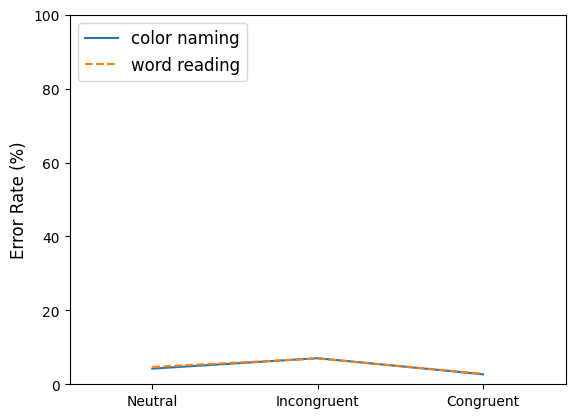

In [ ]:
#### RUN THIS CELL -  PLOT THE NETWORK PERFORMANCE ####
# We use the conditions you have defined in Exercise 2a to determine the response
# probabilities obtained from the StroopNetwork.
responses = simulate_trials(conditions)

# Compute the error rates (by substracting the probability for the correct response
# from 1)
error_rates = compute_error_rates(conditions, responses)

# Visualize the error rates
plot_error_rates(error_rates)

In [ ]:
task_3a = """
the plot does not correspond to what we would expect from a human behaviour.
Identical scaling values applied to the weights and used in respective layers,
lead to uniform activation patterns. This results in similar errors during any of the tasks

"""


###**Exercise 3b. Tweaking Weights to fit Human Data (2 points)<br>**

<font color="green" size=4>
<b>Adjust the StroopNetwork weights in the cell below to roughly recreate the following error response pattern. </b>

<p align='center'><img src='https://raw.githubusercontent.com/jmasis/nntutorialmentaleffort2021/main/stroop_results.png'
alt="3-layer network with bias units" width=500px height=auto/></p>

In this task, you will manually adjust the weights in the StroopNetwork to reproduce the classic behavioral error response pattern seen in human Stroop task experiments. Specifically, the pattern should reflect higher error rates in incongruent conditions compared to congruent or neutral conditions, especially for the color naming task.

<b>Hint 1:</b> *As a guidance, you may experiment with the weights between the range of 1 and 5, including float values. Don't rely entirely on the feedback from the test function. If it tells you it looks plausible while it clearly isn't, you will not get a point.*

<b>Hint 2:</b> *Note that each weight matrix has positive weights on the diagonal (solid lines in the picture below) and negative weights on the anti-diagonal (dashed lines in the picture below). This is because the units of competing colors inhibit each other. E.g., the color input unit for green activates the color hidden unit for green (therefore the positive weight) but deactivates the color hidden unit for red (therefore the negative weight) in the color hidden layer. You can preserve this "cross-inhibition" pattern by playing with the scalars in front of each weight matrix, e.g. `scale_ci_ch` for scaling the weights from the color input layer to the color hidden layer.*

<p align='center'><img src='https://raw.githubusercontent.com/jmasis/nntutorialmentaleffort2021/main/stroop_neural_network_simple_weights_neutral.png'
alt="3-layer network with bias units" width=550px height=auto/></p>

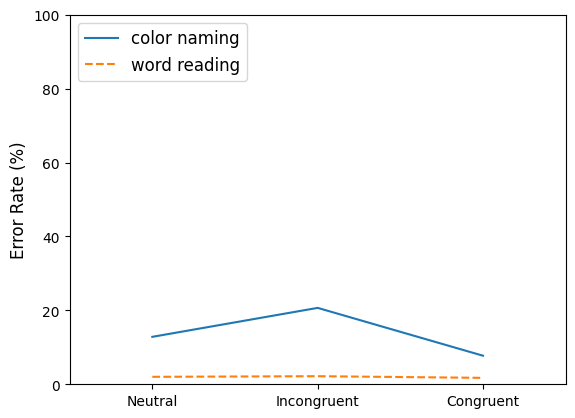

In [ ]:
#### ADJUST THE STROOP NETWORK WEIGHTS ####

class ManualWeights:
  ### SUBTASK B. START ###
  # Weights projecting from color input layer to color hidden layer
  scale_ci_ch =  1.3# Your answer
  c_in_to_c_h = scale_ci_ch * np.array([[1, -1],
                                        [-1, 1]])
  # Weights projecting from color hidden layer to output layer
  scale_ch_co = 1.7# Your answer
  c_h_to_out = scale_ch_co * np.array([[1, -1],
                                        [-1, 1]])
  # Weights projecting from word input layer to word hidden layer
  scale_wi_wh = 2.0# Your answer
  w_in_to_w_h = scale_wi_wh * np.array([[1, -1],
                                        [-1, 1]])
  # Weights projecting from word hidden layer to output layer
  scale_wh_wo = 2.5 # Your answer
  w_h_to_out = scale_wh_wo * np.array([[1, -1],
                                      [-1, 1]])
  # Weights projecting from task layer to color hidden layer
  scale_ti_ch = 4.3# Your answer
  t_in_to_c_h = scale_ti_ch * np.array([[1, 1],
                                        [0, 0]])
  # Weights projecting from task layer to word hidden layer
  scale_ti_wh = 4.3# Your answer
  t_in_to_w_h = scale_ti_wh * np.array([[0, 0],
                                        [1, 1]])
  ### SUBTASK B. END ###

# Simulating Runs with your weights
responses = simulate_trials(conditions, weights=ManualWeights)
error_rates = compute_error_rates(conditions,responses)
plot_error_rates(error_rates)

#problemset3.test_error_rates(error_rates)

### **Exercise 3c. Comment Results (1 point)<br>**

<font color=green size=4><b>What exactly does the plot tell us after the adjusment of the weights? Why is color naming more prone to errors? Provide your answer in less than 50 words.</b>

**Hint (optional):** *You can refer to the <a href="https://psycnet.apa.org/record/1990-27437-001">Cohen et al. (1990)</a> for getting some intution. The paper is also available on StudIP under Files --> Literature --> Topic 3: Neural Network Modeling.*

In [ ]:
task_3c = """
plot shows more observed errors in color naming than word reading.color naming is more prone
to errors due to strong connections in the word pathway. Since the
stimuli is presented as words, it leads to an automatic activation of the word  pathway.
This creates interference during color naming
              <YOUR ANSWER GOES HERE.>

"""


# <font >**Part 2: Fitting the Stroop Model <br>**

## **Introduction to Part 2**

As you may have experienced, it takes quite some time to tweak the weights (i.e., tune its parameters) of a neural network model by hand. Fortunately, this is not a common practice as there are methods to fit the neural network model to data more easily.
In this part of the problem set, we shift our focus from modeling information processing to implementing **model fitting**. There is more than one way to fit a neural network model! While traditional approaches often use optimization algorithms like backpropagation—which involves iteratively updating weights to minimize error—we will instead use a method you are already familiar with: maximum-likelihood estimation (MLE) combined with grid search.

---

### **Why Maximum-Likelihood Estimation and Grid Search?**

Maximum-likelihood estimation provides a principled approach to fit model parameters by identifying values that maximize the likelihood of observed behavior. Grid search is used as a straightforward technique to explore the parameter space systematically. By combining these approaches, we evaluate how well the network predicts observed responses across simulated trials. This method allows us to fit our Stroop model to behavioral data in a computationally simple and interpretable way.

---

### **Simplifying the Model: Transition from Six to Three Weights**

In Part 1 of the problem set, we explored the Stroop model using **six distinct scaling weights**, each corresponding to a specific connection pathway in the network:

- **Color input → Color hidden** -- `scale_ci_ch`
- **Color hidden → Output** -- `scale_ch_out`
- **Word input → Word hidden** -- `scale_wi_wh`
- **Word hidden → Output** -- `scale_wh_out`
- **Task input → Color hidden** -- `scale_ti_ch`
- **Task input → Word hidden** -- `scale_ti_wh`

This configuration was instrumental in understanding how different weights influence the network's behavior. However, when transitioning to **model fitting**, having six independent parameters would make grid search computationally expensive and prone to overfitting.

To address this, we can simplify the model by consolidating the weights into **three pathway-specific scaling parameters**:

- `scale_color`: Governs the color processing pathway (**scale_ci_ch** and **scale_ch_out** merged)
- `scale_word`: Governs the word processing pathway (**scale_wi_wh** and **scale_wh_out** merged)
- `scale_task`: Governs the task processing pathway (**scale_ti_ch** and **scale_ti_wh** merged)

Each of these parameters is shared across their respective connections, reducing the parameter space while retaining the ability to capture key behavioral dynamics. This is generally a good strategy if your model has too many parameters, or if some of them cannot be independently recovered.

We have implemented these changes already in the `StroopNetwork.MergedWeights` class. You can check it from the `StroopNetwork Class` section in Part 1.

---

The updated **MergedWeights** class now incorporates these three consolidated scaling parameters while retaining the feedforward architecture we implemented in Part 1. By transitioning to this structure, we achieve two critical goals:

1. **Consistency with behavioral data**: The default scaling parameters (`scale_color`, `scale_word`, `scale_task`) reproduce the classic error patterns observed in the Stroop task.
2. **Efficiency in model fitting**: Reducing the parameters from six to three significantly accelerates grid search while maintaining interpretability.






## <font color="green">**Exercise 4 - Transforming Simulated Data <br> (1 point)</font>**

In this next step, we provide a helper function to convert the simulation results of the Stroop model into a tabular format (Pandas DataFrame). Additionally, this function samples observed choices for each trial based on the response probabilities generated by the model during the simulation.

**Why do we need this helper function?**
- **Log-Likelihood Calculation**: In later exercises, we will compute the log-likelihood of the model's predictions. To do this, we need access to the model's predicted probabilities and the sampled observed choices for comparison with the true behavioral data.
- **Parameter Fitting**: For fitting the model using grid search, we require a clear, structured representation of the simulation data. The observed choices sampled by this function play a crucial role in evaluating how well the model fits the behavioral data.
- **Simplified Analysis**: By organizing the responses into a DataFrame, we make it easier to analyze, debug, and visualize the model’s behavior.

You do not need to modify the code. Simply run this cell to prepare the necessary DataFrame (`df`) for the upcoming log-likelihood and parameter fitting exercises.

In [ ]:
#############################################
########  RUN THIS HELPER CELL  #############
###### LOGGING THE TRIALS INTO A DF #########
#############################################
def responses_to_dataframe_with_choices(conditions, responses):
    """
    Converts the conditions and responses dictionaries into a Pandas DataFrame,
    and adds a sampled observed choice based on response probabilities.

    Args:
        conditions (dict): Trial conditions with inputs.
        responses (dict): Simulated responses with probabilities.

    Returns:
        DataFrame: Tabular format of the simulation results with observed choices.
    """
    data = []
    for name, response_list in responses.items():
        # Retrieve condition inputs
        color_input, word_input, task_input = conditions[name]

        for response in response_list:
            # Ensure response is a NumPy array
            if isinstance(response, list):
                choice_probabilities = np.array(response).flatten()
            else:
                choice_probabilities = response.flatten()

            # Sample an observed choice based on probabilities
            sampled_choice_index = np.random.choice(
                [0, 1], p=choice_probabilities
            )
            observed_choice = "red" if sampled_choice_index == 0 else "green"

            # Append data for this trial
            data.append({
                'Condition': name,
                'Color_Input': color_input,
                'Word_Input': word_input,
                'Task_Input': task_input,
                'Choice_Probabilities': choice_probabilities.tolist(),
                'Observed_Choice': observed_choice
            })

    # Convert list of trial data into a Pandas DataFrame
    return pd.DataFrame(data)

# Simulate the model with new updated weights
responses = simulate_trials(conditions, weights=StroopNetwork.MergedWeights)
# Transform the responses of the simulation into a dataframe
df = responses_to_dataframe_with_choices(conditions, responses)
# Extract observed choices for log-likelihood calculation
true_choices = df["Observed_Choice"].tolist()

### **Exercise 4a. Variance in Choice Probabilities (1 point)**
<font color="green" size=4> **Print the transformed data by running the code cell below. Where does the variance in choice probabilities for the same condition come from? Provide your answer in less than 50 words.**

*Hint: You can refer to the `simulate_trials` we implemented in Exercise 2*

Run the cell below to generate a cleaned DataFrame summarizing the simulated trials. The DataFrame includes the condition, choice probabilities, and observed choices for each trial.

Take a closer look at the **Choice_Probabilities** column across trials within the same condition. Variance in these probabilities can be observed.


In [ ]:
# Transform the responses of the simulation into a dataframe
df = responses_to_dataframe_with_choices(conditions, responses)

# Drop unnecessary columns for a cleaner display
df_cleaned = df.drop(columns=["Color_Input", "Word_Input", "Task_Input"])

# Group by 'Condition' and print a subset of rows for each condition
for condition, group in df_cleaned.groupby("Condition"):
    print(f"Sample rows for condition: {condition}")
    print(group.head(5))  # Print the first 5 rows of each condition
    print()  # Add a blank line for better readability

Sample rows for condition: cn_congruent
      Condition                        Choice_Probabilities Observed_Choice
0  cn_congruent  [0.9436460033042421, 0.056353996695757906]             red
1  cn_congruent   [0.9556201313230231, 0.04437986867697684]             red
2  cn_congruent  [0.9596796931749033, 0.040320306825096755]             red
3  cn_congruent   [0.9462965638965849, 0.05370343610341505]             red
4  cn_congruent   [0.9417575321427836, 0.05824246785721639]             red

Sample rows for condition: cn_incongruent
         Condition                       Choice_Probabilities Observed_Choice
19  cn_incongruent  [0.7780525131390377, 0.22194748686096233]             red
20  cn_incongruent  [0.7727522419800705, 0.22724775801992944]             red
21  cn_incongruent   [0.7654485782421518, 0.2345514217578481]             red
22  cn_incongruent  [0.7787326280347387, 0.22126737196526125]             red
23  cn_incongruent   [0.7712472363855524, 0.2287527636144477]          

In [ ]:
task_4a = """
the variance in choice probabilities even in same condition is due to the guassian noise added to the
respnse probabilities.The guassian noise introduces some form of randomness which  lead to different
choice probabilities each time we run a simulation

              <YOUR ANSWER GOES HERE.>

"""


## <font color="green">**Exercise 5 - Parameter Fitting <br> (4 points)</font>**
We are finally ready to test if we can recover the model parameters we have used to generate surrogate data. To do so we need a parameter fitting method. We will use the maximum likelihood method, which you are already familiar with from the previous problem sets. To achieve this, we need to implement functions for both calculating the log likelihood as well as performing the grid search.

###  **Exercise 5a. Compute Log Likelihood <br> (2 points)**
<font color="green" size=4> **Complete the missing parts of the code in the `log_likelihood` function to calculate the log likelihood of the model's responses given the observed choices. The log likelihood measures how well the model’s predicted response probabilities align with the observed choices.**

In [ ]:
from logging import log
def log_likelihood(conditions, responses, true_choices):
    """
    Computes the log likelihood of the model's responses given the true observed choices.

    Args:
        conditions (dict): Trial conditions with inputs.
        responses (dict): Simulated responses with probabilities.
        true_choices (list): Observed choices for each trial.

    Returns:
        float: The log likelihood value.
    """
    # Initialize the log likelihood
    LL = 0.0

    # Iterate through each condition and its responses
    for condition_name, response_list in responses.items():
        # Retrieve condition inputs
        color_input, word_input, task_input = conditions[condition_name]

        for i, response in enumerate(response_list):
            # Get the correct choice (true observed choice)
            correct_choice = true_choices[i]
             # Access by index

            ### START EXERCISE 5a. ###
            # Map the choice (e.g., "red" or "green") to its corresponding index
            # HINT: Consider using a dictionary to define the mapping.
            choice_to_index =  {
                "red": 0,
                "green": 1
            }

            # YOUR ANSWER GOES HERE

            # Find the index of the correct choice using the mapping.
            correct_choice_index = choice_to_index[correct_choice]

            # YOUR ANSWER GOES HERE

            # Retrieve the probability of the correct choice from the response.
            # HINT: Access the probability using the index from the response array.
            probability_of_correct = response[0][correct_choice_index]
            # YOUR ANSWER GOES HERE
            ### END EXERCISE 5a. ###

            # Log likelihood update (handling edge cases for log(0))
            LL += np.log(probability_of_correct + 1e-10)  # Add small epsilon to avoid log(0))

    return LL
# If you are not sure you correctly solved the exercise uncomment the line below
log_likelihood = problemset3.log_likelihood


### **Exercise 5b. Implement Grid Search <br> (2 points)**
<font color="green" size=4> **Complete the missing parts of the `grid_search` function to find the best-fitting parameters that maximize the log likelihood.**</font>


For searching the parameter space, we need to implement a search algorithm. Grid search systematically explores all combinations of parameters to find the set that maximizes the log likelihood. Since our model has only three parameters now (`scale_color, scale_word, scale_task`), grid search is computationally feasible.


In [ ]:
def grid_search(conditions, responses, true_choices, param_ranges):
    """
    Performs grid search to find the best parameters by maximizing the log likelihood.

    Args:
        conditions (dict): Trial conditions with inputs.
        responses (dict): Simulated responses with probabilities.
        true_choices (list): Observed choices for each trial.
        param_ranges (dict): Dictionary of parameter ranges, where keys are the parameter names
                             and values are tuples representing the range (min, max).

    Returns:
        dict: Best parameters.
        float: Best log likelihood.
    """
    best_log_likelihood = -np.inf
    best_params = {}

    # Generate the grid of parameter values using linspace for each parameter
    param_values = {param: np.linspace(start, end, num=11)
                    for param, (start, end) in param_ranges.items()}

    # Generate all combinations of parameters
    param_combinations = np.array(np.meshgrid(*param_values.values())).T.reshape(-1, len(param_ranges))

    # Iterate through all combinations of parameter values
    for combination in param_combinations:
        # Create a parameter dictionary from the current combination
        params = {param: combination[i] for i, param in enumerate(param_values.keys())}

        # Create the StroopNetwork.Weights object
        weights = StroopNetwork.MergedWeights()

        # Assign parameter values to the weights object
        weights.c_in_to_c_h = params['scale_color'] * np.array([[1, -1], [-1, 1]])
        weights.c_h_to_out =  params['scale_color'] * np.array([[1, -1], [-1, 1]])
        weights.w_in_to_w_h = params['scale_word']  * np.array([[1, -1], [-1, 1]])
        weights.w_h_to_out =  params['scale_word'] * np.array([[1, -1], [-1, 1]])
        weights.t_in_to_c_h = params['scale_task'] * np.array([[1, 1],  [0, 0]])
        weights.t_in_to_w_h = params['scale_task'] * np.array([[0, 0],  [1, 1]])

        # Simulate responses with the current parameters
        responses = simulate_trials(conditions, weights=weights)

        ### START EXERCISE 5b. ###
        # Compute log likelihood for the current parameters
        log_likelihood_value = log_likelihood(conditions, responses, true_choices)

        # YOUR ANSWER GOES HERE

        # Update best parameters and best LL value if log likelihood improves
        if log_likelihood_value > best_log_likelihood:
          best_log_likelihood = log_likelihood_value
          best_params = params

            # YOUR ANSWER GOES HERE
            # YOUR ANSWER GOES HERE
        ### END EXERCISE 5b. ###

    return best_params, best_log_likelihood

# If you are not sure you correctly solved the exercise uncomment the line below
grid_search = problemset3.grid_search

## <font color="green">**Exercise 6 - Parameter Recovery and Model Evaluation <br> (3 points)</font>**

Now, we have our model and a parameter fitting method. The next step is to validate our model by trying to recover original parameter values we used to simulate our surrogate data.



In [ ]:
# Define the ranges for each parameter using a tuple (min, max)
param_ranges = {
    'scale_color': (1.0, 2.0),   # From 1.0 to 2.0 for scale_color
    'scale_word' : (2.0, 3.0),   # From 1.5 to 2.5 for scale_word
    'scale_task' : (3.5, 4.5)    # From 3.5 to 4.5 for scale_task
}

# Set up a class for fitted weights
class FittedWeights:
    def __init__(self, scale_color, scale_word, scale_task):
        self.c_in_to_c_h = scale_color * np.array([[1, -1], [-1, 1]])
        self.c_h_to_out = scale_color * np.array([[1, -1], [-1, 1]])
        self.w_in_to_w_h = scale_word * np.array([[1, -1], [-1, 1]])
        self.w_h_to_out = scale_word * np.array([[1, -1], [-1, 1]])
        self.t_in_to_c_h = scale_task * np.array([[1, 1], [0, 0]])
        self.t_in_to_w_h = scale_task * np.array([[0, 0], [1, 1]])


# Perform grid search to find the best-fitting parameters
best_params, best_log_likelihood = grid_search(conditions, responses, true_choices, param_ranges)

# Create an instance of FittedWeights using the best parameters
fitted_weights = FittedWeights(
    scale_color=best_params['scale_color'],
    scale_word=best_params['scale_word'],
    scale_task=best_params['scale_task']
)

# Print the recovered parameters and the log likelihood
print("Best Parameters:", best_params)
print("Best Log Likelihood:", best_log_likelihood)

Best Parameters: {'scale_color': 1.5, 'scale_word': 2.0, 'scale_task': 4.2}
Best Log Likelihood: -105.95832456717598


### **Exercise 6a: Compare Model Performance <br> (1 point)**  
<font color="green" size=4> **How do the error rates with the fitted weights differ compare to the error rates with the untrained weights? Briefly describe the changes in error patterns in less than 50 words.**  
</font>



Simulate trials and plot error rates for both *untrained weights* and *fitted weights*. Run the code block below to generate the plots.

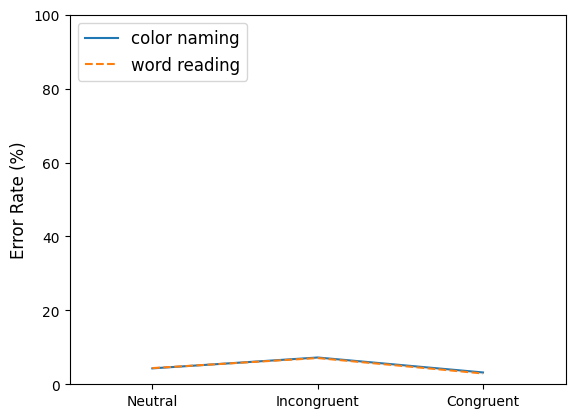

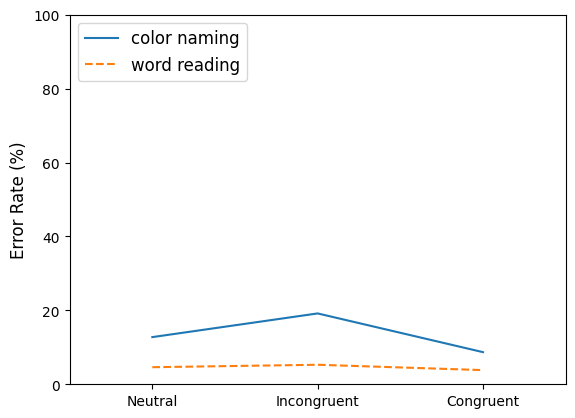

In [ ]:
# Simulate trials with untrained weights
responses = simulate_trials(conditions, weights=StroopNetwork.Weights)
error_rates = compute_error_rates(conditions,responses)
plot_error_rates(error_rates)

# Simulate trials with the fitted weights
responses_fitted = simulate_trials(conditions, weights=fitted_weights)
error_rates = compute_error_rates(conditions,responses_fitted)
plot_error_rates(error_rates)

In [ ]:
task_6a = """
for the untrained weights, same errors(Neutral vs neutral,incongruent vs incongruent,congruent vs congruent) are observed in color naming and word
reading task but for the fitted weights, errors for the three conditions in a color naming task
is higher than the ones during a word reading task.
          <YOUR ANSWER GOES HERE.>

"""

### **Exercise 6b: Compare Model Performance with Human Data <br> (1 point)**  
<font color="green" size=4> **How do the error response pattern with the fitted weights compare to the error response pattern we see with human data? Briefly describe the fitting performance of the model in less than 50 words.**  
</font>

*Hint: Refer to the `Exercise 3b` for the classical error response pattern seen in human data*

In [ ]:
task_6b = """
 the error response pattern with fitted weights do correspond to that of the human data in 3b.
 The fitting performance clearly captures the observed data , similar to that of human data
          <YOUR ANSWER GOES HERE.>

"""

### Exercise 6c. Reflect on the Parameter Recovery Process (1 point)
<font color="green" size=4> **What are the limitations of recovering model parameters using only one weight configuration? How might using multiple configurations improve the evaluation of the parameter recovery process? Provide your answer in less than 50 words.**

Consider the fact that we are simulating and recovering the model using only one weight configuration `MergedWeights`. Reflect on the limitations of this approach.

In [ ]:
task_6c = """
one weight configuration  limits the ability to explore a wider range of potential weight values,
and this can hinder the model's ability to generalize better across multiple stimuli presentation.
This in effect may hinder performance. However,multiple configurations allow for optimal combinations of
weights that ensure better generalization and performance

          <YOUR ANSWER GOES HERE.>

"""

## <font color="green">**Bonus Exercise - Fitting Model to Experimental Data (1 point)<br> </font>**

### **Run the Stroop Experiment**

Click the link below to directly run the Stroop experiment in your browser:

[Run the Stroop Experiment](https://snamazova.github.io/stroop_experiment/stroop_task.html)

*Note: The experiment lasts 100 trials. At the end of the experiment, your data will be automatically downloaded to your local machine. No experimental data is processed online.*


### **Upload Your Experiment Data**

Upload your experiment data `experiment.csv`.

*Note: Make sure that your file is named 'experiment.csv'.*

In [ ]:
#############################################
###### UPLOAD AND LOAD EXPERIMENT DATA ######
#############################################

from google.colab import files

# Prompt the user to upload their CSV file
print("Please upload your experiment data file (experiment.csv):")
uploaded = files.upload()

# Check if the file is successfully uploaded
if 'experiment.csv' in uploaded:
    # Load the file into a pandas DataFrame
    experiment_data = pd.read_csv('experiment.csv')
    print("\nFile uploaded and loaded successfully into the DataFrame: 'experiment_data' ")
else:
    print("\nNo file uploaded. Please try again.")

### **Preprocess the Data**


**NOTE: The preprocessing code is currently not working! As of right now you have to;**

1) process the raw data yourself

2) then, fit the model to your own data.

In [ ]:
# Preprocess the data here

### **Fit Model to Experimental Data (1 point)**
<font color="green" size=4> **Fit the Stroop model to your own behavioral data. Recover model parameters and plot your error response pattern.**


In [ ]:
# YOUR ANSWER GOES HERE